# Image classification using an MLP built using JAX

In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

### Define MLP

In [2]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


### Define forward pass

In [3]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


### Load data

In [4]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int64


### Training and eval loop

In [6]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.2361776
0.09112429
0.056497157
0.041214563
0.0293261
0.031803206
0.041142676
0.025876401
0.04924741
0.02686773
Epoch 0, train acc = 0.9146000146865845 test acc = 0.9179999828338623
0.03284051
0.03281077
0.026975794
0.021163791
0.026344467
0.021186322
0.026046732
0.01790895
0.018019479
0.023230646
Epoch 1, train acc = 0.9344000220298767 test acc = 0.9347999691963196
0.031261556
0.024715064
0.015172662
0.015219559
0.021105967
0.027830172
0.013128218
0.015962472
0.018356316
0.026391307
Epoch 2, train acc = 0.945983350276947 test acc = 0.9443999528884888
0.02015355
0.022461185
0.015126287
0.010397232
0.020076586
0.026202148
0.015229504
0.011004226
0.01608022
0.015883928
Epoch 3, train acc = 0.9517500400543213 test acc = 0.9469999670982361
0.015836097
0.0114797475
0.007395902
0.013064288
0.009908887
0.012467721
0.007155537
0.01854941
0.021818334
0.014526253
Epoch 4, train acc = 0.959516704082489 test acc = 0.9560999870300293


### Show predictions

(28, 28)
pred 7
gt 7


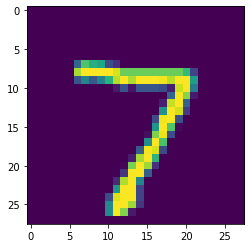

In [7]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

### Visualization

(512, 784)
(28, 28)


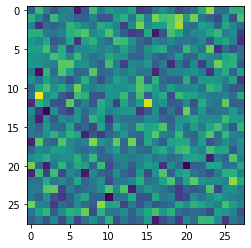

In [8]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()